In [1]:
import tensorflow as tf
import numpy as np

n_features = 28*28
n_outputs = 10

X = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name='X')
y = tf.placeholder(dtype=tf.int32, shape=(None), name='y')

'''
model summary

loss function : cross-entropy
optimizer : tf.GradientDescentOptimizer
---------------------------------------------------
output  : softmax, units=10,    shape=(None, 10)
---------------------------------------------------
hidden1 : relu,    units=100,   shape=(None, 300)
---------------------------------------------------
hidden2 : relu,    units=300,   shape=(None, 100)
---------------------------------------------------
input   :          units=28*28, shape=(None, 28*28)

'''

'\nmodel summary\n\nloss function : cross-entropy\noptimizer : tf.GradientDescentOptimizer\n---------------------------------------------------\noutput  : softmax, units=10,    shape=(None, 10)\n---------------------------------------------------\nhidden1 : relu,    units=100,   shape=(None, 300)\n---------------------------------------------------\nhidden2 : relu,    units=300,   shape=(None, 100)\n---------------------------------------------------\ninput   :          units=28*28, shape=(None, 28*28)\n\n'

In [2]:
def neuron_layer(X, units, name, activation=None):
    with tf.name_scope(name):
        n_input_features = int(X.get_shape()[-1])
        stddev = 2 / np.sqrt(n_input_features+units)
        # Initialize a weight vector filled with random values
        # from a truncated normal distribution.
        init = tf.truncated_normal(shape=(n_input_features, units),
                                   stddev=stddev)
        W = tf.Variable(init, name='kernel')
        b = tf.Variable(tf.zeros([units]), name='bias')
        Z = X @ W + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [3]:
'''
with tf.name_scope('dnn'):
    hidden1 = neuron_layer(X, units=300, activation=tf.nn.relu,
                           name='hidden1')
    hidden2 = neuron_layer(hidden1, units=100, activation=tf.nn.relu,
                           name='hidden2')
    logits = neuron_layer(hidden2, units=n_outputs,
                          name='outputs')
'''

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, units=300, activation=tf.nn.relu,
                              name='hidden1')
    hidden2 = tf.layers.dense(hidden1, units=100, activation=tf.nn.relu,
                              name='hidden2')
    logits = tf.layers.dense(hidden2, units=n_outputs,
                             name='outputs')

In [4]:
with tf.name_scope('loss'):
    crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    loss = tf.reduce_mean(crossentropy, name='loss')

In [5]:
learing_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learing_rate)
    training_op = optimizer.minimize(loss)

In [6]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [7]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [8]:
from sklearn.preprocessing import StandardScaler

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, n_features)/255.0
X_test = X_test.astype(np.float32).reshape(-1, n_features)/255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

n_validation_samples = 5000
X_valid, X_train = X_train[:n_validation_samples], X_train[n_validation_samples:]
y_valid, y_train = y_train[:n_validation_samples], y_train[n_validation_samples:]

In [9]:
def shuffle_batch(X, y, batch_size):
    '''
    Mini-batch generator from mnist dataset.
    '''
    rand_indice = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_indice in np.array_split(rand_indice, n_batches):
        X_batch, y_batch = X[batch_indice], y[batch_indice]
        yield X_batch, y_batch

In [10]:
n_epochs = 100
batch_size = 50

history = {'val_acc':[]}

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        history['val_acc'].append(acc_val)

    save_path = saver.save(sess, './mnist_digit_classifier.ckpt')

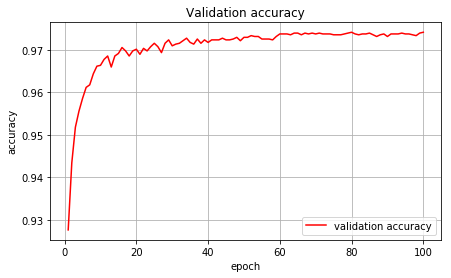

In [12]:
import matplotlib.pyplot as plt

epochs = np.arange(n_epochs) + 1
val_err = history['val_acc']

plt.figure(figsize=(7,4))
plt.title('Validation accuracy')
plt.plot(epochs, val_err, 'r', label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

INFO:tensorflow:Restoring parameters from ./mnist_digit_classifier.ckpt
class=0, probability=4.21852490717356e-08
class=1, probability=1.1226129054131562e-10
class=2, probability=1.4170384310396855e-10
class=3, probability=0.00016342246090061963
class=4, probability=3.6602700579681235e-13
class=5, probability=0.9998331069946289
class=6, probability=8.005371228136937e-07
class=7, probability=6.215374881435309e-10
class=8, probability=7.6230769252561e-08
class=9, probability=2.5128338165814057e-06


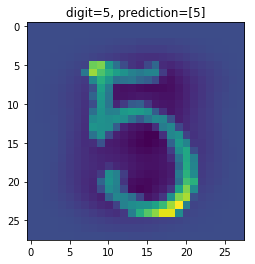

In [27]:
with tf.Session() as sess:
    saver.restore(sess, './mnist_digit_classifier.ckpt')
    rand_index = np.random.randint(0, len(X_test))
    X_new_scaled = X_test[rand_index].reshape(1,-1)
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)
    probabilities = (np.exp(Z) / np.sum(np.exp(Z))).ravel()
    for digit, p in enumerate(probabilities):
        print('class={}, probability={}'.format(digit, p))
    plt.title('digit={}, prediction={}'.format(y_test[rand_index], y_pred))
    plt.imshow(X_new_scaled.reshape(28,28))
    plt.show()